# Observing steps per second

In [1]:
import wandb
import json
import os
import pickle
from collections import defaultdict
import pandas as pd

In [2]:
# glob.glob("runs/**/events.out.tfevents*")

In [3]:
wandb.login()

# Define where to store the cache files
cache_dir = "./wandb_cache/"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

wandb: Currently logged in as: adrian-orenstein (the-orbital-mind). Use `wandb login --relogin` to force relogin


In [36]:
import os
import pickle
import wandb
from concurrent.futures import ThreadPoolExecutor

entity_name = "the-orbital-mind"

PROJECTS = [
    "beluga_8cpu-testing-cartpole-v1-300000",
    "beluga_4cpu_perf_arrayjob-simplified-async-interface-with-dqn-cartpole-v1-None",
    "m1_mac-simplified-async-interface-with-dqn-cartpole-v1-None",
]

for project_name in PROJECTS:
    api = wandb.Api(timeout=20)
    runs = api.runs(f"{entity_name}/{project_name}")
    
    # Define where to store the cache files
    cache_dir = "./wandb_cache/"
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    def process_run(job):
        (i, run) = job
    
        cache_path = os.path.join(cache_dir, f"{run.id}.pkl")
    
        # Check if we have cached data
        if not os.path.exists(cache_path):
            df = run.history()
            with open(cache_path, 'wb') as file:
                pickle.dump(df, file)
            print(f"Data cached for run: {run.id}, {i/len(runs):0.2}")
        # else:
        #     print(f"Already cached run: {run.id}, {i/len(runs):0.2}")
    
    # Use ThreadPoolExecutor to handle the runs in parallel
    with ThreadPoolExecutor(max_workers=8) as executor:
        executor.map(process_run, (enumerate(runs)))


In [37]:
len(runs)

810

In [38]:
from collections import defaultdict
data = defaultdict(dict)

for project_name in PROJECTS:
    api = wandb.Api(timeout=20)
    runs = api.runs(f"{entity_name}/{project_name}")
    data[project_name] = defaultdict(list)
    for run in runs:
        cache_path = os.path.join(cache_dir, f"{run.id}.pkl")
        if run.state != "finished":
            # print(cache_path)
            continue
            
        config = {k:v.get('value') for k, v in json.loads(run.json_config).items()}
    
        if config.get('async_datarate') is None:
            continue
    
        if os.path.exists(cache_path):
            run_df = pd.read_pickle(cache_path)
        else:
            run_df = run.history()
            run_df.to_pickle(cache_path)
    
        df = run_df[['charts/episodic_return']]
    
        dic = dict(df[~df['charts/episodic_return'].isnull()].mean())
    
        data[project_name][config.get('async_datarate')].append(dic.get('charts/episodic_return'))


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
data.keys()

dict_keys(['beluga_8cpu-testing-cartpole-v1-300000', 'beluga_4cpu_perf_arrayjob-simplified-async-interface-with-dqn-cartpole-v1-None', 'm1_mac-simplified-async-interface-with-dqn-cartpole-v1-None'])

In [53]:
renamed_data = {
    "Cluster 4 CPUs (100% Util)": data["beluga_8cpu-testing-cartpole-v1-300000"],
    "Cluster 8 CPUs (60% Util)": data["beluga_4cpu_perf_arrayjob-simplified-async-interface-with-dqn-cartpole-v1-None"],
    "M1 Pro 8 CPUs (40% Util)": data["m1_mac-simplified-async-interface-with-dqn-cartpole-v1-None"],
}


In [54]:
data["m1_mac-simplified-async-interface-with-dqn-cartpole-v1-None"]

defaultdict(list,
            {27000: [12.959016393442623,
              12.640081799591002,
              12.70182555780933,
              12.692622950819672,
              12.609756097560975,
              13.079918032786885,
              12.237113402061855,
              12.028571428571428,
              12.572597137014315,
              12.526530612244898,
              13.334710743801653,
              13.393004115226338],
             26000: [12.861283643892339,
              13.32172131147541,
              13.307377049180328,
              13.382716049382717,
              13.466804979253112,
              13.362886597938145,
              12.816494845360825,
              12.904081632653062,
              13.62962962962963,
              12.62551440329218,
              13.94639175257732,
              13.34156378600823,
              13.77938144329897,
              13.837448559670781,
              13.607361963190185,
              13.283095723014256,
              13.19077

/var/folders/5j/dky4yd9d2dbd8j9kbs3l2ltr0000gn/T/ipykernel_77875/848960096.py:34: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(x="Environment Step Rate", y="Mean Episodic Return", hue="Device", data=df, palette=palette, errorbar=('ci', 95), ax=ax)


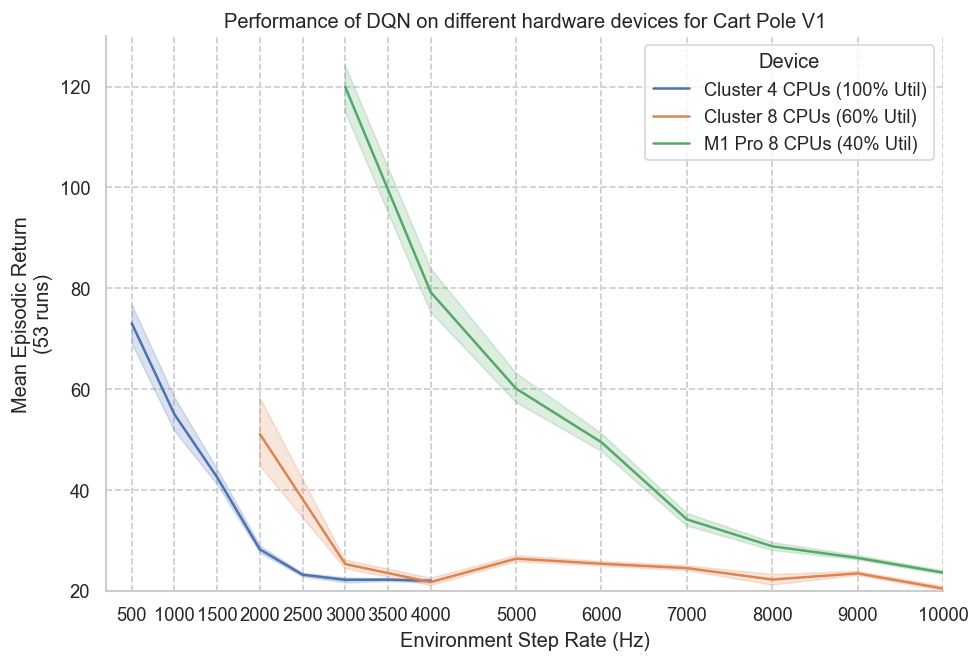

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
# Consolidating all data into a single DataFrame with an additional 'Device' column
all_data_points = []

for device, project_data in renamed_data.items():
    for step_rate, values in project_data.items():
        for value in values:
            all_data_points.append({
                "Device": device,
                "Environment Step Rate": step_rate,
                "Mean Episodic Return": value
            })

adf = pd.DataFrame(all_data_points)

df = adf[(adf['Device'] != "M1 Pro 8 CPUs (40% Util)") | ((adf['Device'] == "M1 Pro 8 CPUs (40% Util)") & (adf['Environment Step Rate'] > 2800))]


step_rates = [entry['Environment Step Rate'] for entry in all_data_points]
step_rate_counts = Counter(step_rates)

# Apply a theme for better aesthetics
sns.set(style="whitegrid")

# Choosing a color palette
palette = sns.color_palette("deep")

# Plotting
fig, ax = plt.subplots(figsize=(9, 6), dpi=120)
sns.lineplot(x="Environment Step Rate", y="Mean Episodic Return", hue="Device", data=df, palette=palette, errorbar=('ci', 95), ax=ax)
ax.set_title("Performance of DQN on different hardware devices for Cart Pole V1")
ax.set_xlabel("Environment Step Rate (Hz)")  # Updated xlabel for clarity in units

# Convert step rates to kHz for x-axis labels
labels = sorted(df['Environment Step Rate'].unique())
new_labels = [label for label in labels]  # Convert to kHz
ax.set_xticks(labels)
ax.set_xticklabels(new_labels, rotation=0, ha='center', rotation_mode='anchor')

seeds = np.array([count for rate, count in step_rate_counts.items() if 2000 <= rate <= 4000]).mean()
ax.set_ylabel("\n".join(["Mean Episodic Return", f"({int(seeds)} runs)"]))

ax.grid(True, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(200, 10000)
ax.set_ylim(20, 130)

# Enhance the grid and axes visibility
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Save the figure
fig.savefig('performance_comparison_on_diff_hardware.svg', format='svg')

In [12]:
"ratio and mean episodic return"

'ratio and mean episodic return'

In [58]:
import os
import pickle
import wandb
from concurrent.futures import ThreadPoolExecutor

entity_name = "the-orbital-mind"

PROJECTS = [
    "beluga_4cpu-testing-acrobot-v1-300000",
    "beluga_4cpu-testing-cartpole-v1-300000",
    "beluga_4cpu-testing-lunarlander-v2-300000",
    "beluga_4cpu-testing-mountaincar-v0-300000",
    "beluga_8cpu-testing-lunarlander-v2-300000",
    "beluga_8cpu-testing-acrobot-v1-300000",
    "beluga_8cpu-testing-mountaincar-v0-300000",
    "beluga_8cpu-testing-cartpole-v1-300000",
]

for project_name in PROJECTS:
    api = wandb.Api(timeout=20)
    runs = api.runs(f"{entity_name}/{project_name}")
    
    # Define where to store the cache files
    cache_dir = "./wandb_cache/"
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    def process_run(job):
        (i, run) = job
    
        cache_path = os.path.join(cache_dir, f"{run.id}.pkl")
    
        # Check if we have cached data
        if not os.path.exists(cache_path):
            df = run.history()
            with open(cache_path, 'wb') as file:
                pickle.dump(df, file)
            # print(f"Data cached for run: {run.id}, {i/len(runs):0.2}")
        # else:
        #     print(f"Already cached run: {run.id}, {i/len(runs):0.2}")
    
    # Use ThreadPoolExecutor to handle the runs in parallel
    from concurrent.futures import ThreadPoolExecutor
    from tqdm import tqdm
    
    with ThreadPoolExecutor(max_workers=32) as executor:
        tasks = [(i, run) for i, run in enumerate(runs)]
        tqdm(executor.map(process_run, tasks), total=len(tasks), desc=f'{project_name}')




beluga_8cpu-testing-cartpole-v1-300000:   0%|                        | 0/239 [00:00<?, ?it/s]


In [59]:
from collections import defaultdict
import pandas as pd
import wandb

# Initialize wandb API
api = wandb.Api(timeout=20)

# Prepare data storage
data = []

# Fetch and process data
for project_name in PROJECTS:
    runs = api.runs(f"{entity_name}/{project_name}")
    for i, run in enumerate(runs):
        if run.state != "finished":
            continue
        
        config = {k: v.get('value') for k, v in json.loads(run.json_config).items()}
        if config.get('async_datarate') is None:
            continue
        
        cache_path = os.path.join(cache_dir, f"{run.id}.pkl")
        if os.path.exists(cache_path):
            run_df = pd.read_pickle(cache_path)
        else:
            run_df = run.history(keys=['charts/episodic_return', 'environment/ratio'])
            run_df.to_pickle(cache_path)
        
        mean_values = run_df.mean()
        data.append({'mean_episodic_return': mean_values['charts/episodic_return'], 'mean_ratio': mean_values['environment/ratio'], 'project_name': project_name})

In [60]:
wandb_m1_export_of_m1_and_cartpole = pd.read_csv('wandb_export_m1_cartpole.csv')
filtered_data = wandb_m1_export_of_m1_and_cartpole.dropna(subset=['environment/agent_environment_sps_ratio'])
# Rename columns in m1_cartpole_data to match project_data
filtered_data = filtered_data.rename(columns={
    'Name': 'project_name',
    'environment/agent_environment_sps_ratio': 'mean_ratio',
    'charts/episodic_return': 'mean_episodic_return'
}, inplace=False)

m1_cartpole_data = filtered_data.copy()

# Add additional columns to match the structure if needed
m1_cartpole_data['environment'] = 'cartpole'
m1_cartpole_data['cpu'] = 'M1'

# Append M1 CartPole data to project_data
m1_cartpole_data

,project_name,mean_ratio,mean_episodic_return,environment,cpu
1,CartPole-v1__dqn__11__778645,0.589516,9.0,cartpole,M1
2,CartPole-v1__dqn__10__778509,1.291518,8.0,cartpole,M1
3,CartPole-v1__dqn__9__778375,0.553498,11.0,cartpole,M1
4,CartPole-v1__dqn__8__778241,1.341011,9.0,cartpole,M1
5,CartPole-v1__dqn__7__778105,5.106377,10.0,cartpole,M1
...,...,...,...,...,...
804,CartPole-v1__dqn__0__711921,0.370125,29.0,cartpole,M1
805,CartPole-v1__dqn__0__711848,0.621337,34.0,cartpole,M1
806,CartPole-v1__dqn__0__711773,0.327250,76.0,cartpole,M1
807,CartPole-v1__dqn__0__711707,0.254748,10.0,cartpole,M1


In [61]:
project_data = pd.concat([pd.DataFrame(data), m1_cartpole_data], ignore_index=True)
project_data

,mean_episodic_return,mean_ratio,project_name,environment,cpu
0,-215.719765,0.924822,beluga_4cpu-testing-acrobot-v1-300000,NaN,NaN
1,-234.943067,0.878616,beluga_4cpu-testing-acrobot-v1-300000,NaN,NaN
2,-218.163636,0.901742,beluga_4cpu-testing-acrobot-v1-300000,NaN,NaN
3,-241.041617,0.941491,beluga_4cpu-testing-acrobot-v1-300000,NaN,NaN
4,-268.319363,0.738521,beluga_4cpu-testing-acrobot-v1-300000,NaN,NaN
...,...,...,...,...,...
2605,29.000000,0.370125,CartPole-v1__dqn__0__711921,cartpole,M1
2606,34.000000,0.621337,CartPole-v1__dqn__0__711848,cartpole,M1
2607,76.000000,0.327250,CartPole-v1__dqn__0__711773,cartpole,M1
2608,10.000000,0.254748,CartPole-v1__dqn__0__711707,cartpole,M1


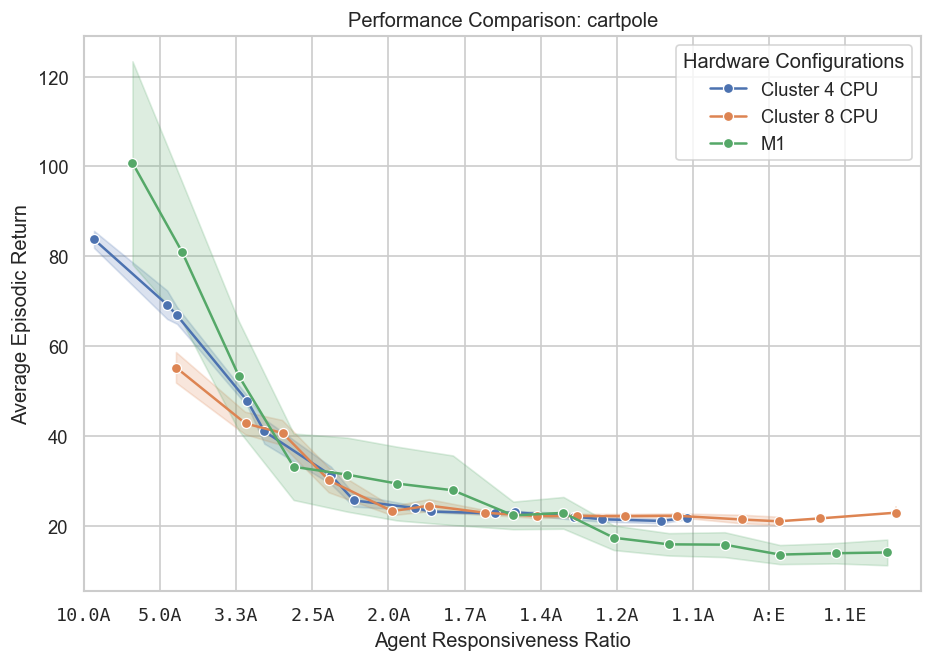

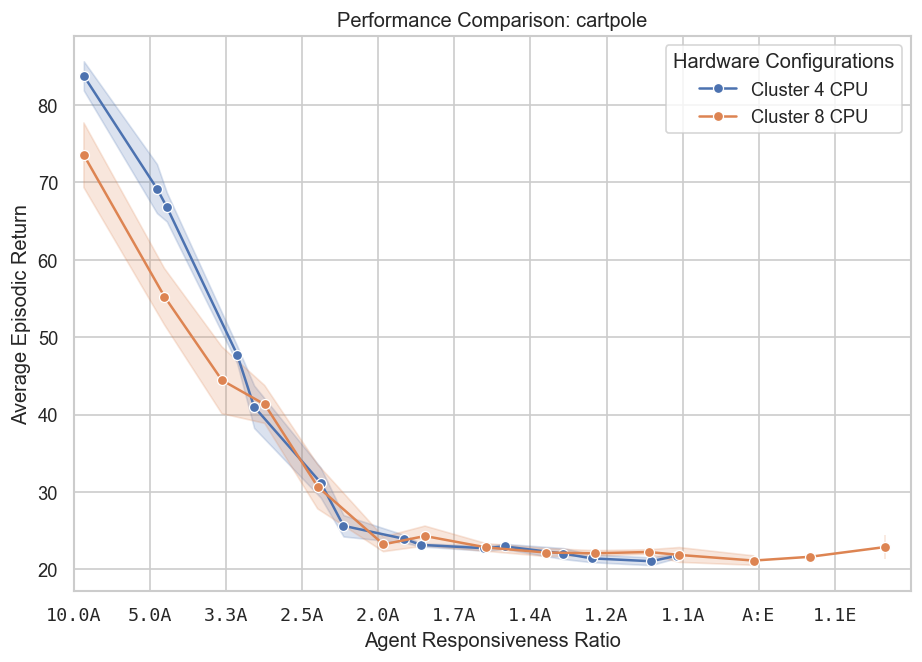

Figure: Performance comparison for the cartpole environment across different CPU configurations. The plots show averaged episodic returns over binned ratio intervals with 95% confidence intervals, revealing the effect of varying completion ratios on performance.


In [65]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Convert data to DataFrame for plotting
project_data = pd.DataFrame(data)

# Setting up Seaborn globally
sns.set(style="whitegrid")
palette = sns.color_palette("deep")

# Extract environment and CPU details from 'project_name'
project_data['environment'] = project_data['project_name'].apply(lambda x: x.split('-')[2])
project_data['cpu'] = project_data['project_name'].apply(lambda x: x.split('-')[0])

project_data = pd.concat([project_data, m1_cartpole_data], ignore_index=True)

# Get unique environments
environments = project_data['environment'].unique()

x_axis_ranges = {
    'acrobot': (0.1,1), 
    'cartpole': (0.1, 1.2), 
    'lunarlander': (0.1, 1.05), 
    'mountaincar': (0.1, 1),
}

y_axis_ranges = {
    'acrobot': (-375,-110), 
    'cartpole': (0, 200), 
    'lunarlander': (-250, -50), 
    'mountaincar': (-220, -125),
}

prettier_name = {
    'beluga_4cpu': 'Cluster 4 CPU',
    'beluga_8cpu': 'Cluster 8 CPU',
    "M1": "M1"
}

# Define the mapping function for x-axis labels
def format_ratio(ratio):
    if ratio == 1:
        return "A:E"  # Agent and environment move at the same speed
    elif ratio > 1:
        return f"{round(ratio, 1)}E"  # Agent is faster than the environment
    elif ratio < 1:
        return f"{round(1/ratio, 1)}A"  # Agent is faster than the environment
    return "Inf A:E"  # Fallback for any unforeseen zero or negative scenarios, which shouldn't occur


# Iterate over each environment
for env in ['cartpole']:#environments:
    
    # Filter data for the current environment
    env_data = project_data[project_data['environment'] == env]
    
    # Get unique CPUs for this environment
    cpus = env_data['cpu'].unique()
    x_min, x_max = x_axis_ranges[env]
    y_min, y_max = y_axis_ranges[env]

    if "M1" in cpus:
        fig, ax = plt.subplots(figsize=(9, 6), dpi=120)
        for i, cpu in enumerate(cpus):
            # Filter data for this CPU
            cpu_data = env_data[env_data['cpu'] == cpu].copy()  # Make a copy explicitly for safe operations
            
            # Filter the DataFrame
            cpu_data = cpu_data[
                (cpu_data['mean_ratio'] > x_min) & 
                (cpu_data['mean_ratio'] < x_max) &
                (cpu_data['mean_episodic_return'] > y_min) & 
                (cpu_data['mean_episodic_return'] < y_max) 
            ]

            if cpu == 'beluga_8cpu':
                cpu_data = cpu_data[(cpu_data['mean_ratio'] > (0.2)) & (cpu_data['mean_ratio'] < x_max)]
            
            # Define bins for 'mean_ratio'
            cpu_data['ratio_bin'] = pd.cut(cpu_data['mean_ratio'], bins=15, labels=False)
            
            # Group and calculate mean and SEM by bin
            binned_data = cpu_data.groupby('ratio_bin')['mean_episodic_return'].agg(['mean', 'sem', 'count']).reset_index()
    
    
            
            # Calculate 95% confidence interval (approximation)
            binned_data['lower'] = binned_data['mean'] - 1.96 * binned_data['sem']
            binned_data['upper'] = binned_data['mean'] + 1.96 * binned_data['sem']
    
            # Re-assign 'mean_ratio' to the center of each bin for plotting purposes
            bin_centers = [cpu_data.loc[cpu_data['ratio_bin'] == bin, 'mean_ratio'].mean() for bin in binned_data['ratio_bin']]
            binned_data['mean_ratio'] = bin_centers
    
            # Plotting using Seaborn
            # sns.scatterplot(x=cpu_data['mean_ratio'], y=cpu_data['mean_episodic_return'], s=50, alpha=0.4, marker='o', color=palette[i])
            line = sns.lineplot(x=binned_data['mean_ratio'], y=binned_data['mean'], marker='o', linestyle='-', label=f'{prettier_name[cpu]}', color=palette[i])
            
            # Get the line color to use for the CI shading
            line_color = line.lines[0].get_color()
            
            plt.fill_between(binned_data['mean_ratio'], binned_data['lower'], binned_data['upper'], color=palette[i], alpha=0.2)

        # Adding plot titles and labels
        plt.title(f'Performance Comparison: {env}')
        plt.xlabel('Agent Responsiveness Ratio')
        plt.ylabel('Average Episodic Return')
        plt.legend(title='Hardware Configurations')
        plt.grid(True)
    
        # Set tick values for ratio decimals that result in whole numbers after formatting
        tick_vals = np.arange(0.1, 1.2, 0.1)
        # tick_vals = [1, 0.7, 0.6, 0.5, 0.4]
        tick_labels = [format_ratio(tick) for tick in tick_vals]
        ax.set_xticks(tick_vals)
        ax.set_xticklabels(tick_labels, fontfamily='monospace')
    
        ax.set_xlim(x_min, x_max)
        if env == 'mountaincar':
            ax.set_ylim(-220, -125)
        
        # Save the figure with a unique name for each environment
        plt.savefig(f'{env}_performance_comparison_with_m1.svg', format='svg')
        
        # Display the plot
        plt.show()

    fig, ax = plt.subplots(figsize=(9, 6), dpi=120)
    cpus = [c for c in cpus if c != "M1"]

    for i, cpu in enumerate(cpus):
        # Filter data for this CPU
        cpu_data = env_data[env_data['cpu'] == cpu].copy()  # Make a copy explicitly for safe operations
        
        # Filter the DataFrame
        cpu_data = cpu_data[
            (cpu_data['mean_ratio'] > x_min) & 
            (cpu_data['mean_ratio'] < x_max) &
            (cpu_data['mean_episodic_return'] > y_min) & 
            (cpu_data['mean_episodic_return'] < y_max) 
        ]
        
        # Define bins for 'mean_ratio'
        cpu_data['ratio_bin'] = pd.cut(cpu_data['mean_ratio'], bins=15, labels=False)
        
        # Group and calculate mean and SEM by bin
        binned_data = cpu_data.groupby('ratio_bin')['mean_episodic_return'].agg(['mean', 'sem', 'count']).reset_index()


        
        # Calculate 95% confidence interval (approximation)
        binned_data['lower'] = binned_data['mean'] - 1.96 * binned_data['sem']
        binned_data['upper'] = binned_data['mean'] + 1.96 * binned_data['sem']

        # Re-assign 'mean_ratio' to the center of each bin for plotting purposes
        bin_centers = [cpu_data.loc[cpu_data['ratio_bin'] == bin, 'mean_ratio'].mean() for bin in binned_data['ratio_bin']]
        binned_data['mean_ratio'] = bin_centers

        # Plotting using Seaborn
        # sns.scatterplot(x=cpu_data['mean_ratio'], y=cpu_data['mean_episodic_return'], s=50, alpha=0.4, marker='o', color=palette[i])
        line = sns.lineplot(x=binned_data['mean_ratio'], y=binned_data['mean'], marker='o', linestyle='-', label=f'{prettier_name[cpu]}', color=palette[i])
        
        # Get the line color to use for the CI shading
        line_color = line.lines[0].get_color()
        
        plt.fill_between(binned_data['mean_ratio'], binned_data['lower'], binned_data['upper'], color=palette[i], alpha=0.2)

    # Adding plot titles and labels
    plt.title(f'Performance Comparison: {env}')
    plt.xlabel('Agent Responsiveness Ratio')
    plt.ylabel('Average Episodic Return')
    plt.legend(title='Hardware Configurations')
    plt.grid(True)

    # Set tick values for ratio decimals that result in whole numbers after formatting
    tick_vals = np.arange(0.1, 1.2, 0.1)
    # tick_vals = [1, 0.7, 0.6, 0.5, 0.4]
    tick_labels = [format_ratio(tick) for tick in tick_vals]
    ax.set_xticks(tick_vals)
    ax.set_xticklabels(tick_labels, fontfamily='monospace')

    ax.set_xlim(x_min, x_max)
    if env == 'mountaincar':
        ax.set_ylim(-220, -125)
    
    # Save the figure with a unique name for each environment
    plt.savefig(f'{env}_performance_comparison.svg', format='svg')
    
    # Display the plot
    plt.show()
    
        
    
    

    # Caption
    print(f"Figure: Performance comparison for the {env} environment across different CPU configurations. The plots show averaged episodic returns over binned ratio intervals with 95% confidence intervals, revealing the effect of varying completion ratios on performance.")
